In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold
import numpy as np

In [2]:
# Veriyi OpenML'den yükleyelim

# fetch dataset
car_evaluation = fetch_ucirepo(id=19)
X = car_evaluation.data.features
y = car_evaluation.data.targets

df = X

df['class'] = y

In [3]:
# boş değer var mı kontrol edelim

df.isnull().sum()

# boş değer yok

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

In [4]:
# hepsi kategorik veri olduğu için herhangi bir korelasyon ilişkisi net olarak kurulamayacağından ötürü kullanmamaktayız.
# korelasyon grafiği eğer birbiriyle yükske korelasyona sahip featureler varsa birini kaldırabilmek için işe yarar çünkü curse of dimensionality gereği ne kadar öz nitelkili feature var ise o kadar iyi olur

In [5]:
df['buying'].unique()

array(['vhigh', 'high', 'med', 'low'], dtype=object)

In [6]:
df['maint'].unique()

array(['vhigh', 'high', 'med', 'low'], dtype=object)

In [7]:
df['doors'].unique()

array(['2', '3', '4', '5more'], dtype=object)

In [8]:
df['persons'].unique()

array(['2', '4', 'more'], dtype=object)

In [9]:
df['lug_boot'].unique()

array(['small', 'med', 'big'], dtype=object)

In [10]:
df['safety'].unique()

array(['low', 'med', 'high'], dtype=object)

In [11]:
# bütün featurelar kategorik, hiçbiri continuoues feature değil.
# bütün featurelar kategoriksel olduğu için normalization veyahut standardization ihtiyacı yoktur.
# bütün bu featureları encodelayalım.

df_features = df.iloc[:,:-1]

df_oht = pd.get_dummies(df_features, columns = df_features.columns)
df_oht['class'] = df['class']
df_oht


,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med,class
0,False,False,False,True,False,False,False,True,True,False,...,True,False,False,False,False,True,False,True,False,unacc
1,False,False,False,True,False,False,False,True,True,False,...,True,False,False,False,False,True,False,False,True,unacc
2,False,False,False,True,False,False,False,True,True,False,...,True,False,False,False,False,True,True,False,False,unacc
3,False,False,False,True,False,False,False,True,True,False,...,True,False,False,False,True,False,False,True,False,unacc
4,False,False,False,True,False,False,False,True,True,False,...,True,False,False,False,True,False,False,False,True,unacc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,False,True,False,False,False,True,False,False,False,False,...,False,False,True,False,True,False,False,False,True,good
1724,False,True,False,False,False,True,False,False,False,False,...,False,False,True,False,True,False,True,False,False,vgood
1725,False,True,False,False,False,True,False,False,False,False,...,False,False,True,True,False,False,False,True,False,unacc
1726,False,True,False,False,False,True,False,False,False,False,...,False,False,True,True,False,False,False,False,True,good


C:\Users\cavsl\AppData\Local\Temp\ipykernel_22580\1043221009.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


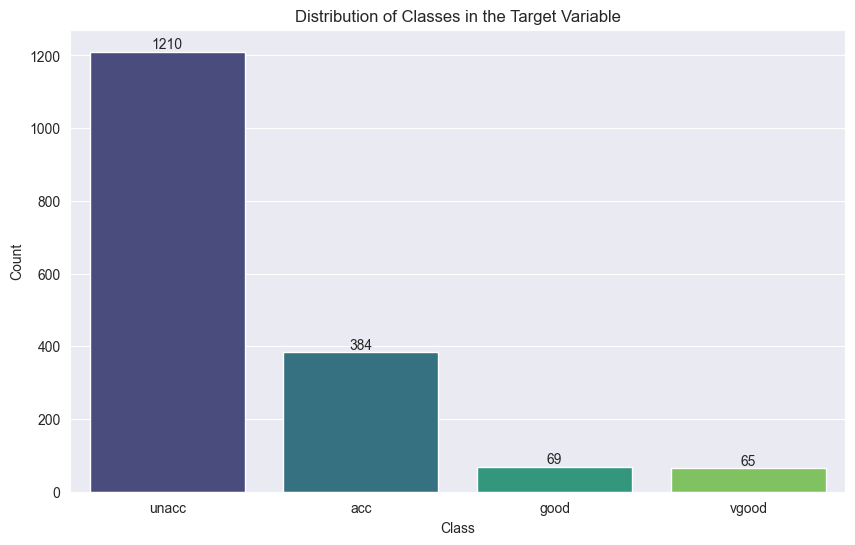

In [12]:
# class değerlerinin miktarlarını kontrol edelim
# Count the number of instances in each class
class_counts = df['class'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')

# Annotate the bars with the counts
for i in range(len(class_counts)):
    plt.text(i, class_counts.values[i], class_counts.values[i], ha='center', va='bottom')

plt.title('Distribution of Classes in the Target Variable')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [13]:
print((class_counts['unacc']/df.shape[0])* 100)

#70% unaccaptable target var. Undersample veya oversample yapmak gerekebilir çünkü 1700 satırın çoğunluğu unaccaptable olduğundan model good ve very good classlarını gerektiği kadar öğrenemeyebilir.

# oversample az olan değerleri arttırma ile ilgilidir ve bizim örneğimiz için zor seçenek. Undersample ise adeti fazla olanı indirgeme ile ilgilidir.
# fakat sorun verinin az olması. 1700 satırlık veriyi daha da aza indirgersek modelin performansı düşebilir. Bu durumda her iki seçenek de değerlendirilip undersample olan ve olmayan olarak iki farklı case incelenecektir.

# undersample yapılmayan durumda model skoru daha yüksek çıkabilir fakat moderin ne kadar tutarlı olduğu farklı bir konudur. Her ne kadar model accuracy yüksek olsa da güvenirliği düşük olabilir. Bu durumda k fold split ile modelin güvenirliğini overfit veya underfit olma durumları da incelencektir.

70.02314814814815


In [14]:
df_oht

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med,class
0,False,False,False,True,False,False,False,True,True,False,...,True,False,False,False,False,True,False,True,False,unacc
1,False,False,False,True,False,False,False,True,True,False,...,True,False,False,False,False,True,False,False,True,unacc
2,False,False,False,True,False,False,False,True,True,False,...,True,False,False,False,False,True,True,False,False,unacc
3,False,False,False,True,False,False,False,True,True,False,...,True,False,False,False,True,False,False,True,False,unacc
4,False,False,False,True,False,False,False,True,True,False,...,True,False,False,False,True,False,False,False,True,unacc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,False,True,False,False,False,True,False,False,False,False,...,False,False,True,False,True,False,False,False,True,good
1724,False,True,False,False,False,True,False,False,False,False,...,False,False,True,False,True,False,True,False,False,vgood
1725,False,True,False,False,False,True,False,False,False,False,...,False,False,True,True,False,False,False,True,False,unacc
1726,False,True,False,False,False,True,False,False,False,False,...,False,False,True,True,False,False,False,False,True,good


In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


X = df_oht.iloc[:,:-1].values
y = df_oht['class'].values


# Further split the train set into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

kf = KFold(n_splits=5)

knn_accuracy_scores = []
knn_val_accuracy_scores = []

dt_accuracy_scores = []
dt_val_accuracy_scores = []

bys_accuracy_scores = []
bys_val_accuracy_scores = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Train your model on X_train_fold, y_train_fold
    # Evaluate your model on X_val_fold, y_val_fold

    # KNN ------------------------------------------------------------------------------
    # Initialize the KNN classifier with k=3
    knn = KNeighborsClassifier(n_neighbors=5)

    # Train the classifier
    knn.fit(X_train_fold, y_train_fold)

    # Predict the labels for the test data
    predictions = knn.predict(X_test_fold)

    accuracy = accuracy_score(y_test_fold, predictions)

    knn_accuracy_scores.append(accuracy)

     # Predict the labels for the validation data
    val_prediction = knn.predict(X_test)

    val_accuracy = accuracy_score(y_test, val_prediction)

    knn_val_accuracy_scores.append(val_accuracy)
    # ------------------------------------------------------------------------------------

    # DECISION TREE-----------------------------------------------------------------------
    decision_tree = DecisionTreeClassifier(random_state=42)

    # Train the classifier
    decision_tree.fit(X_train_fold, y_train_fold)

    # Predict the labels for the test data
    predictions = decision_tree.predict(X_test_fold)

    accuracy = accuracy_score(y_test_fold, predictions)

    dt_accuracy_scores.append(accuracy)

     # Predict the labels for the validation data
    val_prediction = decision_tree.predict(X_test)

    val_accuracy = accuracy_score(y_test, val_prediction)

    dt_val_accuracy_scores.append(val_accuracy)
    #--------------------------------------------------------------------------------------

    # BAYESIAN TREE-----------------------------------------------------------------------
    naive_bayes = GaussianNB()

    # Train the classifier
    naive_bayes.fit(X_train_fold, y_train_fold)

    # Predict the labels for the test data
    predictions = naive_bayes.predict(X_test_fold)

    accuracy = accuracy_score(y_test_fold, predictions)

    bys_accuracy_scores.append(accuracy)

     # Predict the labels for the validation data
    val_prediction = naive_bayes.predict(X_test)

    val_accuracy = accuracy_score(y_test, val_prediction)

    bys_val_accuracy_scores.append(val_accuracy)
    #--------------------------------------------------------------------------------------

In [16]:
accuracy_scores = {'KNN': knn_accuracy_scores, 'DECISION_TREE':dt_accuracy_scores, 'NAIVE BAYES' : bys_accuracy_scores}

accuracy_scores

{'KNN': [0.9097472924187726,
  0.9205776173285198,
  0.8876811594202898,
  0.927536231884058,
  0.8586956521739131],
 'DECISION_TREE': [0.9638989169675091,
  0.9675090252707581,
  0.9637681159420289,
  0.9637681159420289,
  0.9347826086956522],
 'NAIVE BAYES': [0.8194945848375451,
  0.8483754512635379,
  0.782608695652174,
  0.7898550724637681,
  0.7681159420289855]}

In [17]:
mean_accuracy_scores = {}

for model, scores in accuracy_scores.items():
    mean_accuracy_scores[model] = sum(scores) / len(scores)


mean_accuracy_scores


{'KNN': 0.9008475906451107,
 'DECISION_TREE': 0.9587453565635954,
 'NAIVE BAYES': 0.8016899492492021}

In [18]:
# bu üç modelin k fold sonucu ortalama accuracy değerleri. Bunlara bakılırsa Decision tree kullanarak model kurarsak güvenirliği en yüksek olacak.
# overfit olma durumu olabilir. Overfit ise train test kullanırken skorun çok yüksek gelmesi fakat hiç görmediği data üzerinde yanlış tahminler yapması ve accuracy skorunun çok düşük kalması durumudur.
# bunu anlayabilmemiz için k folda sokmadan önce ayırdığımız 20% lik validation seti üzerinde deneme yaptık.

val_accuracy_scores = {'VALIDATION KNN': knn_val_accuracy_scores, 'VALIDATION DECISION_TREE':dt_val_accuracy_scores, 'VALIDATION NAIVE BAYES' : bys_val_accuracy_scores}
val_mean_accuracy_scores = {}

for model, scores in val_accuracy_scores.items():
    val_mean_accuracy_scores[model] = sum(scores) / len(scores)

val_mean_accuracy_scores

# buradan sonuçlara bakılırsa hiç görmediği data üzerinde de decision tree yüksek skor elde ediyor. Bu da modelin overfite düşmediğini gösteriyor.

# Özetle validaiton set sonucu overfitin olmadığı, k fold sonucu da modelin güvenilir olduğunu anlayarak decision tree'nin en iyi skoru verdiğini görebiliriz.

{'VALIDATION KNN': 0.8751445086705202,
 'VALIDATION DECISION_TREE': 0.9549132947976877,
 'VALIDATION NAIVE BAYES': 0.8063583815028903}

In [19]:
# Initialize the KNN classifier with k=3
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)

accuracy = accuracy_score(y_test, predictions)

accuracy

0.8757225433526011

In [20]:
df.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [21]:
row = np.array([['vhigh', 'vhigh', 3, 4, 'med', 'low']])

row = np.array([['vhigh', 'vhigh', 3, 4, 'med', 'low']])

knn.predict(row)

ValueError: dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.

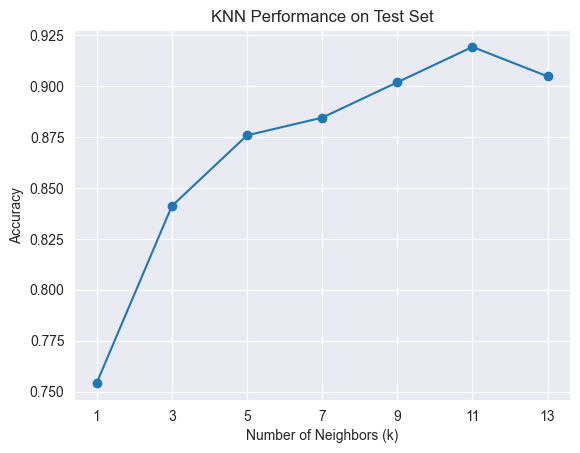

In [22]:
k_values = [1, 3, 5, 7, 9, 11,13]

# Initialize lists to store accuracy scores
accuracy_scores = []

# Train KNN classifier for each value of k and calculate accuracy on the test set
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)

# Plot the graph
plt.plot(k_values, accuracy_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Performance on Test Set')
plt.xticks(k_values)
plt.grid(True)
plt.show()

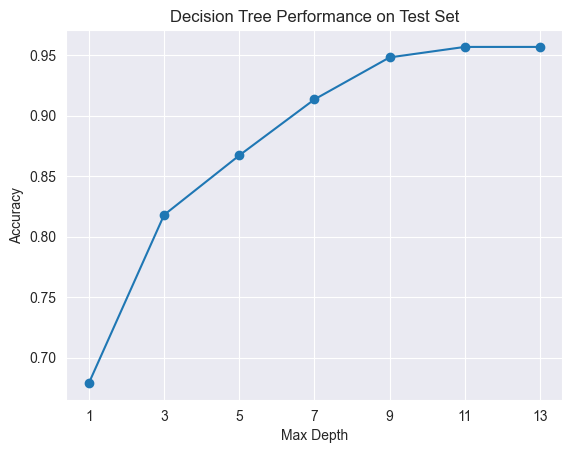

In [23]:
max_depth_values = [1, 3, 5, 7, 9, 11, 13]
accuracy_scores = []

# Train Decision Tree classifier for each value of max_depth and calculate accuracy on the test set
for max_depth in max_depth_values:
    decision_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    decision_tree.fit(X_train, y_train)
    predictions = decision_tree.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)

# Plot the graph
plt.plot(max_depth_values, accuracy_scores, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Decision Tree Performance on Test Set')
plt.xticks(max_depth_values)
plt.grid(True)
plt.show()

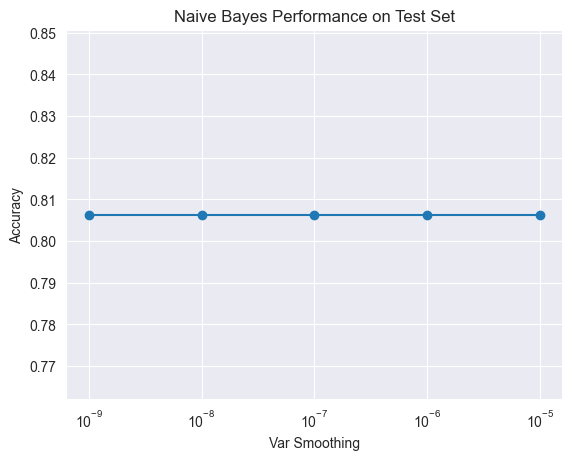

In [24]:
var_smoothing_values = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]

# Initialize lists to store accuracy scores
accuracy_scores = []

# Train Naive Bayes classifier for each value of var_smoothing and calculate accuracy on the test set
for var_smoothing in var_smoothing_values:
    naive_bayes = GaussianNB(var_smoothing=var_smoothing)
    naive_bayes.fit(X_train, y_train)
    predictions = naive_bayes.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)

# Plot the graph
plt.plot(var_smoothing_values, accuracy_scores, marker='o')
plt.xlabel('Var Smoothing')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Performance on Test Set')
plt.xscale('log')
plt.grid(True)
plt.show()

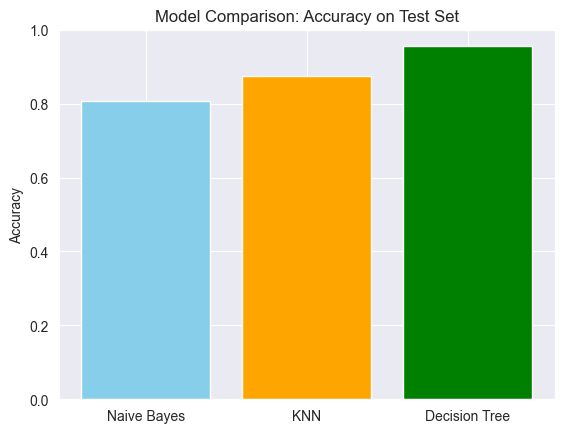

In [25]:
# Initialize and train Naive Bayes classifier
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)
predictions_nb = naive_bayes.predict(X_test)
accuracy_nb = accuracy_score(y_test, predictions_nb)

# Initialize and train KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
predictions_knn = knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, predictions_knn)

# Initialize and train Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)
predictions_dt = decision_tree.predict(X_test)
accuracy_dt = accuracy_score(y_test, predictions_dt)

# Combine accuracy scores into a list
models = ['Naive Bayes', 'KNN', 'Decision Tree']
accuracies = [accuracy_nb, accuracy_knn, accuracy_dt]

# Plot the accuracies in a bar graph
plt.bar(models, accuracies, color=['skyblue', 'orange', 'green'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy on Test Set')
plt.show()